In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
# 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # For Korean characters
plt.rcParams['axes.unicode_minus'] = False  # To display negative signs correctly

In [28]:
match_info = pd.read_csv('data/match_info.csv')
raw_data = pd.read_csv('data/raw_data.csv')

In [29]:
raw_data.head(30)

,game_id,action_id,period_id,time_seconds,team_id,player_id,result_name,start_x,start_y,end_x,end_y,dx,dy,type_name,player_name_ko,team_name_ko,position_name,main_position
0,126288,0,1,1.033,2353,356625.0,Successful,52.670205,34.919632,68.628945,34.347412,15.958740,-0.572220,Pass,이영준,김천 상무 프로축구단,CF,CF
1,126288,1,1,2.433,2353,356612.0,NaN,68.628945,34.347412,68.628945,34.347412,0.000000,0.000000,Pass Received,원두재,김천 상무 프로축구단,CDM,CM
2,126288,2,1,3.033,2353,356612.0,Successful,68.228055,33.853256,65.468865,26.640292,-2.759190,-7.212964,Pass,원두재,김천 상무 프로축구단,CDM,CM
3,126288,3,1,4.333,2353,356618.0,NaN,65.468865,26.640292,65.468865,26.640292,0.000000,0.000000,Pass Received,김진규,김천 상무 프로축구단,CM,CM
4,126288,4,1,4.900,2353,356618.0,Successful,64.838025,26.766636,63.300510,43.018024,-1.537515,16.251388,Pass,김진규,김천 상무 프로축구단,CM,CM
5,126288,5,1,6.300,2353,356624.0,NaN,63.300510,43.018024,63.300510,43.018024,0.000000,0.000000,Pass Received,강현묵,김천 상무 프로축구단,CM,CM
6,126288,6,1,6.301,2353,356624.0,NaN,63.300510,43.018024,58.171995,47.553624,-5.128515,4.535600,Carry,강현묵,김천 상무 프로축구단,CM,CM
7,126288,7,1,10.114,2353,356624.0,Successful,58.171995,47.553624,65.107770,37.462016,6.935775,-10.091608,Pass,강현묵,김천 상무 프로축구단,CM,CM
8,126288,8,1,11.467,2353,356612.0,NaN,65.107770,37.462016,65.107770,37.462016,0.000000,0.000000,Pass Received,원두재,김천 상무 프로축구단,CDM,CM
9,126288,9,1,11.468,2353,356612.0,NaN,65.107770,37.462016,62.281800,43.225628,-2.825970,5.763612,Carry,원두재,김천 상무 프로축구단,CDM,CM


In [30]:
# 팀별 패스 성공률
pass_data = raw_data[raw_data['type_name'] == 'Pass'].copy()
team_pass_stats = pass_data.groupby('team_name_ko').agg({
    'result_name': lambda x: (x == 'Successful').sum() / len(x) * 100,
    'game_id': 'count'
}).rename(columns={'result_name': '패스_성공률(%)', 'game_id': '총_패스_수'})

In [31]:
# 팀별 슈팅 효율성
shot_data = raw_data[raw_data['type_name'].isin(['Shot', 'Shot_Freekick'])].copy()
team_shot_stats = shot_data.groupby('team_name_ko').agg({
    'game_id': 'count',
    'result_name': lambda x: (x == 'Goal').sum()
}).rename(columns={'game_id': '총_슈팅_수', 'result_name': '골_수'})
team_shot_stats['슈팅_성공률(%)'] = (team_shot_stats['골_수'] / team_shot_stats['총_슈팅_수'] * 100).round(2)

# 유효슈팅 비율
on_target = shot_data.groupby('team_name_ko')['result_name'].apply(
    lambda x: (x.isin(['On Target', 'Goal'])).sum() / len(x) * 100
).rename('유효슈팅_비율(%)')

team_shot_stats = team_shot_stats.join(on_target)


In [32]:
# 공격/수비 스타일 분석
# 공격 지표
attack_actions = ['Pass', 'Cross', 'Shot', 'Take-On', 'Carry']
attack_data = raw_data[raw_data['type_name'].isin(attack_actions)]
team_attack = attack_data.groupby('team_name_ko').size().rename('공격_액션_수')

# 수비 지표
defense_actions = ['Tackle', 'Interception', 'Clearance', 'Block']
defense_data = raw_data[raw_data['type_name'].isin(defense_actions)]
team_defense = defense_data.groupby('team_name_ko').size().rename('수비_액션_수')

# 경기당 평균으로 정규화
games_per_team = match_info.groupby('home_team_name_ko').size() + match_info.groupby('away_team_name_ko').size()
games_per_team = games_per_team.fillna(0)

team_style = pd.DataFrame({
    '경기당_공격_액션': (team_attack / games_per_team).round(1),
    '경기당_수비_액션': (team_defense / games_per_team).round(1)
})


In [33]:
# 홈/어웨이 경기 성적
home_stats = match_info.groupby('home_team_name_ko').agg({
    'home_score': 'sum',
    'away_score': 'sum',
    'game_id': 'count'
}).rename(columns={'home_score': '홈_득점', 'away_score': '홈_실점', 'game_id': '홈_경기수'})

away_stats = match_info.groupby('away_team_name_ko').agg({
    'away_score': 'sum',
    'home_score': 'sum',
    'game_id': 'count'
}).rename(columns={'away_score': '원정_득점', 'home_score': '원정_실점', 'game_id': '원정_경기수'})


In [34]:
# 승점 계산
def calculate_points(row):
    if row['home_score'] > row['away_score']:
        return 3, 0
    elif row['home_score'] < row['away_score']:
        return 0, 3
    else:
        return 1, 1

match_info[['home_points', 'away_points']] = match_info.apply(
    calculate_points, axis=1, result_type='expand'
)

home_points = match_info.groupby('home_team_name_ko')['home_points'].sum()
away_points = match_info.groupby('away_team_name_ko')['away_points'].sum()

In [35]:
# 결과 출력
print("=" * 60)
print("1. 팀별 패스 성공률")
print("=" * 60)
print(team_pass_stats.sort_values('패스_성공률(%)', ascending=False))

print("\n" + "=" * 60)
print("2. 팀별 슈팅 효율성")
print("=" * 60)
print(team_shot_stats.sort_values('슈팅_성공률(%)', ascending=False))

print("\n" + "=" * 60)
print("3. 팀별 공격/수비 스타일")
print("=" * 60)
print(team_style.sort_values('경기당_공격_액션', ascending=False))

print("\n" + "=" * 60)
print("4. 홈 vs 원정 승점")
print("=" * 60)
home_away_comparison = pd.DataFrame({
    '홈_승점': home_points,
    '원정_승점': away_points,
    '총_승점': home_points + away_points
}).sort_values('총_승점', ascending=False)
print(home_away_comparison)


1. 팀별 패스 성공률
              패스_성공률(%)  총_패스_수
team_name_ko                   
광주FC          89.133655   15525
울산 HD FC      87.725799   17272
포항 스틸러스       87.612584   15766
강원FC          87.210793   14825
FC서울          87.182557   15869
수원FC          86.909449   15240
전북 현대 모터스     85.951033   14663
김천 상무 프로축구단   85.717256   14430
인천 유나이티드      85.545840   15096
대전 하나 시티즌     84.236131   13772
대구FC          83.842795   12595
제주SK FC       83.790376   13529

2. 팀별 슈팅 효율성
              총_슈팅_수  골_수  슈팅_성공률(%)  유효슈팅_비율(%)
team_name_ko                                    
강원FC             389   53      13.62   38.303342
FC서울             349   47      13.47   40.401146
울산 HD FC         382   49      12.83   42.408377
포항 스틸러스          365   44      12.05   35.068493
전북 현대 모터스        345   41      11.88   29.565217
대전 하나 시티즌        290   30      10.34   36.551724
수원FC             424   43      10.14   33.254717
김천 상무 프로축구단      435   42       9.66   33.793103
대구FC             409   37       9.0

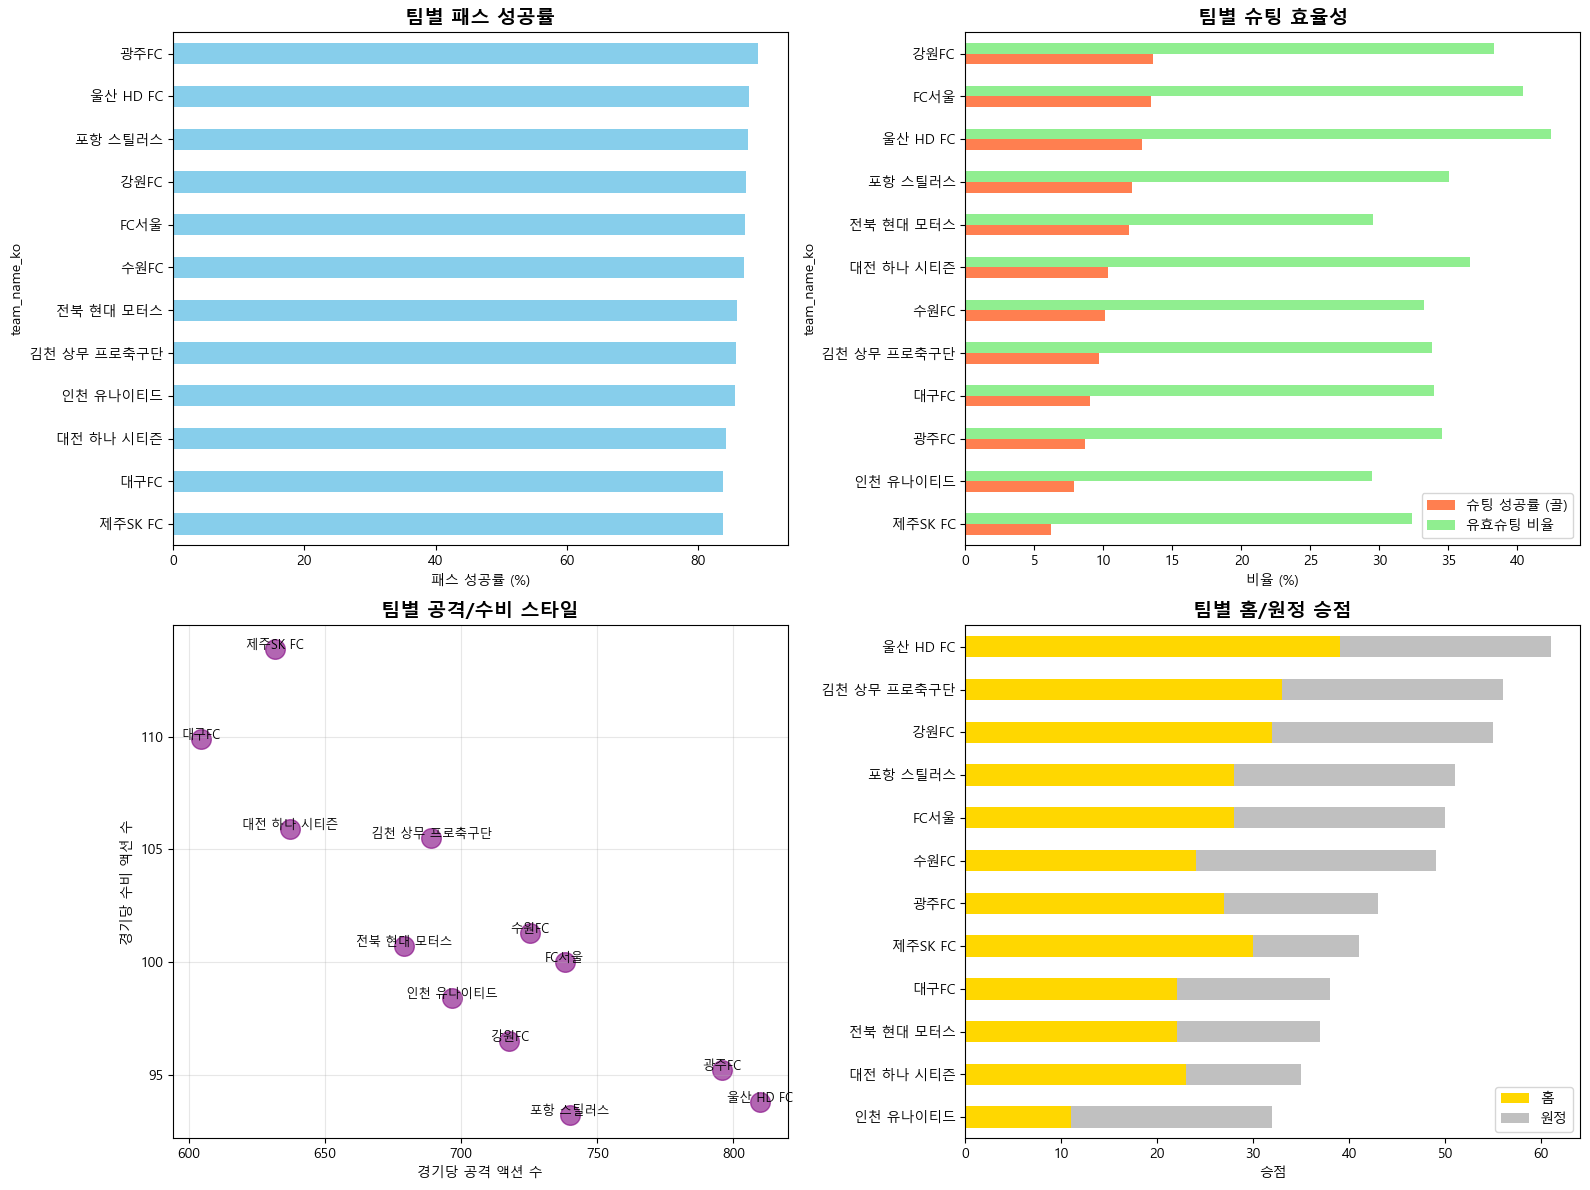

In [36]:
# 시각화
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. 팀별 패스 성공률
team_pass_stats.sort_values('패스_성공률(%)').plot(
    kind='barh', y='패스_성공률(%)', ax=axes[0, 0], color='skyblue', legend=False
)
axes[0, 0].set_title('팀별 패스 성공률', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('패스 성공률 (%)')

# 2. 팀별 슈팅 효율성
team_shot_stats.sort_values('슈팅_성공률(%)')[['슈팅_성공률(%)', '유효슈팅_비율(%)']].plot(
    kind='barh', ax=axes[0, 1], color=['coral', 'lightgreen']
)
axes[0, 1].set_title('팀별 슈팅 효율성', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('비율 (%)')
axes[0, 1].legend(['슈팅 성공률 (골)', '유효슈팅 비율'])

# 3. 공격/수비 스타일
axes[1, 0].scatter(team_style['경기당_공격_액션'], team_style['경기당_수비_액션'], 
                   s=200, alpha=0.6, c='purple')
for idx, row in team_style.iterrows():
    axes[1, 0].annotate(idx, (row['경기당_공격_액션'], row['경기당_수비_액션']),
                        fontsize=9, ha='center')
axes[1, 0].set_xlabel('경기당 공격 액션 수')
axes[1, 0].set_ylabel('경기당 수비 액션 수')
axes[1, 0].set_title('팀별 공격/수비 스타일', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. 홈 vs 원정 승점
home_away_comparison.sort_values('총_승점')[['홈_승점', '원정_승점']].plot(
    kind='barh', stacked=True, ax=axes[1, 1], color=['gold', 'silver']
)
axes[1, 1].set_title('팀별 홈/원정 승점', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('승점')
axes[1, 1].legend(['홈', '원정'])

plt.tight_layout()
plt.show()
